In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from google.colab import drive

drive.mount('/content/gdrive', force_remount=True)
filepath = '/content/gdrive/MyDrive' + '/Colab Notebooks/csv/'
mnist = np.load(filepath + 'mnist.npz')

x_train = (mnist['x_train'] - np.mean(mnist['x_train'])) / np.std(mnist['x_train'])
y_train = mnist['y_train']
x_test = (mnist['x_test'] - np.mean(mnist['x_train'])) / np.std(mnist['x_train'])
y_test = mnist['y_test']
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

Mounted at /content/gdrive
(60000, 28, 28) (60000,) (10000, 28, 28) (10000,)


In [ ]:
def to_onehot(labels, num_classes):
    return np.eye(num_classes)[labels]

y_train_onehot = to_onehot(y_train, 10)
y_test_onehot = to_onehot(y_test, 10)

print(y_train_onehot.shape, y_test_onehot.shape)

(60000, 10) (10000, 10)


In [ ]:
x_train_small = x_train[:, ::4, ::4].reshape(-1, 7*7)
x_test_small = x_test[:, ::4, ::4].reshape(-1, 7*7)

print(x_train_small.shape, x_test_small.shape)

(60000, 49) (10000, 49)


In [ ]:
class Linear:
    def __init__(self, in_features, out_features):
        self.weight = np.random.rand(in_features, out_features)
        self.bias = np.random.rand(out_features)

    def forward(self, x):
        self.input = x
        x = np.dot(x, self.weight) + self.bias

        return x
    
    def backward(self, grad_output, learning_rate):
        grad_weight = np.dot(self.input.T, grad_output)
        grad_bias = np.sum(grad_output, axis=0)
        grad_input = np.dot(grad_output, self.weight.T)

        self.weight = self.weight - learning_rate * grad_weight
        self.bias = self.bias - learning_rate * grad_bias
        
        return grad_input

In [ ]:
class ReLU:
    def forward(self, x):
        self.input = x
        return np.maximum(x, 0)
    
    def backward(self, grad_output):
        grad_input = grad_output.copy()
        grad_input[self.input < 0] = 0
        return grad_input

In [ ]:
class softmax:
    def forward(self, x):
        exps = np.exp(x - np.max(x, axis=1, keepdims=True))
        probs = exps / np.sum(exps, axis=1, keepdims=True)
        return probs

    def backward(self, grad_output):
        grad_input = grad_output.copy()
        return grad_input

In [ ]:
class MLP:
    def __init__(self, input_size, hidden_size, output_size, learning_rate):
        self.layer1 = Linear(input_size, hidden_size)
        self.relu = ReLU()
        self.layer2 = Linear(hidden_size, output_size)
        self.softmax = softmax()
        self.learning_rate = learning_rate
    
    def forward(self, x):
        x = self.layer1.forward(x)
        x = self.relu.forward(x)
        x = self.layer2.forward(x)
        x = self.softmax.forward(x)
        return x
    
    def backward(self, y_true, y_pred):
        grad_output = y_pred - y_true
        grad_output /= len(y_true)

        grad_output = self.softmax.backward(grad_output)
        grad_output = self.layer2.backward(grad_output, self.learning_rate)
        grad_output = self.relu.backward(grad_output)
        grad_output = self.layer1.backward(grad_output, self.learning_rate)

In [ ]:
def cross_entropy(y_true, y_pred):
    y_true = np.argmax(y_true, axis=-1)
    y_pred = y_pred[np.arange(y_true.shape[0]), y_true]

    return -np.mean(np.log(y_pred + 1e-8))

mlp = MLP(input_size=49, hidden_size=64, output_size=10, learning_rate=5e-2)

In [ ]:
epoch = 5000

losses = []
for i in tqdm(range(epoch)):
    y_pred = mlp.forward(x_train_small) 
    losses.append(cross_entropy(y_train_onehot, y_pred))
    
    mlp.backward(y_train_onehot, y_pred) 
losses = np.array(losses) 

100%|██████████| 5000/5000 [23:14<00:00,  3.59it/s]


<function matplotlib.pyplot.show(close=None, block=None)>

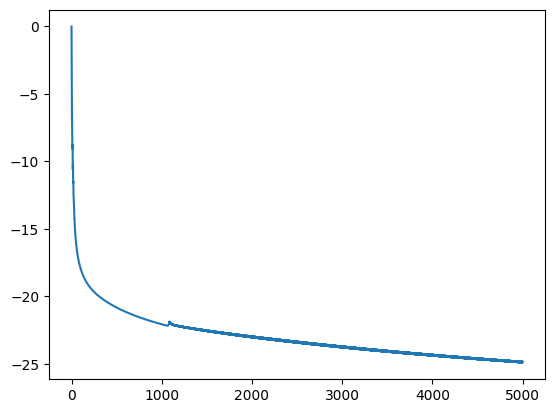

In [ ]:
plt.plot(10.0 * np.log(losses / np.max(losses + 1e-8)))
plt.show

In [ ]:
from sklearn.metrics import accuracy_score

y_pred_onehot = mlp.forward(x_test_small)
y_pred = np.argmax(y_pred_onehot, axis=1)

acc = accuracy_score(y_test, y_pred)
print(acc)

0.786
